In [1]:
# this notebook adapts https://github.com/BIGBALLON/CIFAR-ZOO
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from easydict import EasyDict as edict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
args = edict()
args.batch_size = 64
args.log_interval = 100
args.data_dir = './data'
args.lr = 0.03
args.momentum = 0.9
args.epochs = 50
args.lr_drop_epoch = 30
args.seed = 1
args.no_shuffle = False
print(args)

{'batch_size': 64, 'log_interval': 100, 'data_dir': './data', 'lr': 0.03, 'momentum': 0.9, 'epochs': 50, 'lr_drop_epoch': 30, 'seed': 1, 'no_shuffle': False}


In [0]:
# fix all seeds for reproducibility
seed = args.seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
def _init_fn(worker_id):
    np.random.seed(int(seed))

In [4]:
use_cuda = True
batch_size = args.batch_size
test_batch_size = args.batch_size

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root=args.data_dir, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=not args.no_shuffle, **kwargs)

testset = datasets.CIFAR10(root=args.data_dir, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, **kwargs)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def train(args, model, device, train_loader, optimizer, epoch,
          scheduler=None):
    model.train()
    train_loss = 0
    correct = 0
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        train_loss += loss.item() * data.shape[0]  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            elapsed = time.time() - start_time
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | ms/batch {:5.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                elapsed * 1000 / args.log_interval))
            start_time = time.time()
        if scheduler is not None:
            scheduler.step()
    train_loss /= len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, train_acc

In [0]:
def test(args, model, device, test_loader,
         evalmode=True):
    if evalmode:
        model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [0]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        w = 16
        self.conv_1 = nn.Conv2d(3, 6 * w, 5)
        self.bn_1 = nn.BatchNorm2d(6 * w)
        self.conv_2 = nn.Conv2d(6 * w, 16 * w, 5)
        self.bn_2 = nn.BatchNorm2d(16 * w)
        self.fc_1 = nn.Linear(16 * 5 * 5 * w, 120 * w)
        self.bn_fc1 = nn.BatchNorm1d(120 * w)
        self.fc_2 = nn.Linear(120 * w, 84 * w)
        self.bn_fc2 = nn.BatchNorm1d(84 * w)
        self.fc_3 = nn.Linear(84 * w, num_classes)
        self.out_ln = nn.LayerNorm(num_classes, elementwise_affine =False)

    def forward(self, x):
        out = F.relu(self.conv_1(x))
        out = self.bn_1(out)
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv_2(out))
        out = self.bn_2(out)
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = self.bn_fc1(out)
        out = F.relu(self.fc_2(out))
        out = self.bn_fc2(out)
        out = self.fc_3(out)
        out = self.out_ln(out)
        return out

class LinearModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.lin = nn.Linear(3 * 1024, num_classes)
    def forward(self, x):
        x = x.view(-1, 3 * 1024)
        return self.lin(x)


In [0]:
net = LeNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, args.lr_drop_epoch)
logs = []

In [9]:
for epoch in range(1, args.epochs+1):
    epoch_start_time = time.time()
    train_loss, train_acc, = train(args, net, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(args, net, device, test_loader)
    logs.append(dict(
        epoch=epoch,
        train_loss=train_loss,
        train_acc=train_acc,
        valid_loss=test_loss,
        valid_acc=test_acc
    ))
    scheduler.step()
    print('epoch time: {:5.2f}s'.format(time.time() - epoch_start_time))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.873882 | ms/batch  4.33
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.607184 | ms/batch 17.40
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.515400 | ms/batch 17.61
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.478027 | ms/batch 17.42
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.459535 | ms/batch 16.99
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.196419 | ms/batch 17.30
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.218459 | ms/batch 16.95
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.186644 | ms/batch 17.59

Train set: Average loss: 1.3347, Accuracy: 27982/50000 (56%)


Test set: Average loss: 1.1014, Accuracy: 6590/10000 (66%)

epoch time: 15.94s
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.943249 | ms/batch  1.10
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.974293 | ms/batch 17.31
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.011122 | ms/batch 17.31
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.949685 | ms/batch 17.33
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.008860 | ms/batch 17.9

In [0]:
logdf = pd.DataFrame(logs)

In [11]:
best_loss_epoch, best_loss = logdf.sort_values(by='valid_loss')[['epoch', 'valid_loss']].to_numpy()[0]
best_acc_epoch, best_acc = logdf.sort_values(by='valid_acc', ascending=False)[['epoch', 'valid_acc']].to_numpy()[0]
print(f'Best validation loss is {best_loss:.4f}, achieved at epoch {int(best_loss_epoch)}.\n'
      f'But best validation accuracy is {best_acc}, achieved much later at epoch {int(best_acc_epoch)}.')

Best validation loss is 0.9017, achieved at epoch 4.
But best validation accuracy is 0.7633, achieved much later at epoch 48.


In [0]:
def tight_layout(fig):
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

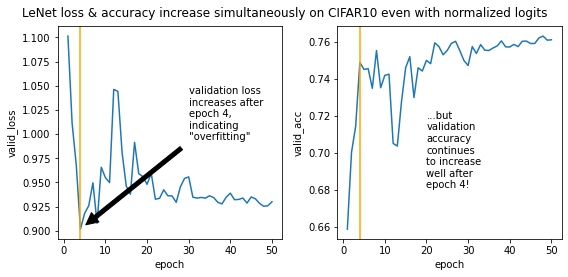

In [13]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
sns.lineplot(data=logdf, x='epoch', y='valid_loss')
plt.axvline(best_loss_epoch, c='orange')
plt.annotate(f'validation loss\nincreases after\nepoch {int(best_loss_epoch)},\nindicating\n"overfitting"',
            xy=(best_loss_epoch, best_loss),  xycoords='data',
            xytext=(30, 1.05), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',
             wrap=True
            )
plt.subplot(122)
sns.lineplot(data=logdf, x='epoch', y='valid_acc')
plt.axvline(best_loss_epoch, c='orange')
plt.text(20, 0.68,
         f'...but\nvalidation\naccuracy\ncontinues\nto increase\nwell after\nepoch {int(best_loss_epoch)}!',
         horizontalalignment='left', verticalalignment='bottom')
plt.suptitle('LeNet loss & accuracy increase simultaneously on CIFAR10 even with normalized logits')
tight_layout(plt)
plt.savefig('lenet-normalized-logits.png', dpi=200, bbox_inches='tight')

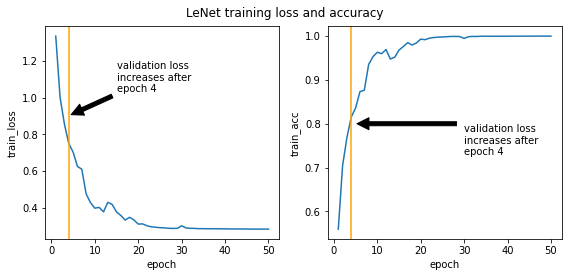

In [14]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
sns.lineplot(data=logdf, x='epoch', y='train_loss')
plt.axvline(best_loss_epoch, c='orange')
plt.annotate(f'validation loss\nincreases after\nepoch {int(best_loss_epoch)}',
            xy=(best_loss_epoch, best_loss),  xycoords='data',
            xytext=(15, 1.2), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',
             wrap=True
            )
plt.subplot(122)
sns.lineplot(data=logdf, x='epoch', y='train_acc')
plt.axvline(best_loss_epoch, c='orange')
plt.annotate(f'validation loss\nincreases after\nepoch {int(best_loss_epoch)}',
            xy=(best_loss_epoch, .8),  xycoords='data',
            xytext=(30, 0.8), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top',
             wrap=True
            )
plt.suptitle('LeNet training loss and accuracy')
tight_layout(plt)
plt.savefig('lenet-normalized-logits-training.png', dpi=200, bbox_inches='tight')